In [27]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
%pwd

'/home/qiao/dev/giao/havingfun/detecting/segmentation/unet34'

In [29]:
print(torch.cuda.is_available())

True


In [30]:
path = Path('/home/qiao/dev/giao/datasets/')

path_img = path/'S_google_wildfire/'
path_label = path/'S_google_wildfire_label/'
codes = ['Smoke', 'Flame', 'Cloud', 'Background']
path_img

Path('/home/qiao/dev/giao/datasets/S_google_wildfire')

In [31]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiao/dev/giao/datasets/S_google_wildfire/009.png


In [32]:
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiao/dev/giao/datasets/S_google_wildfire_label/Label_001.png


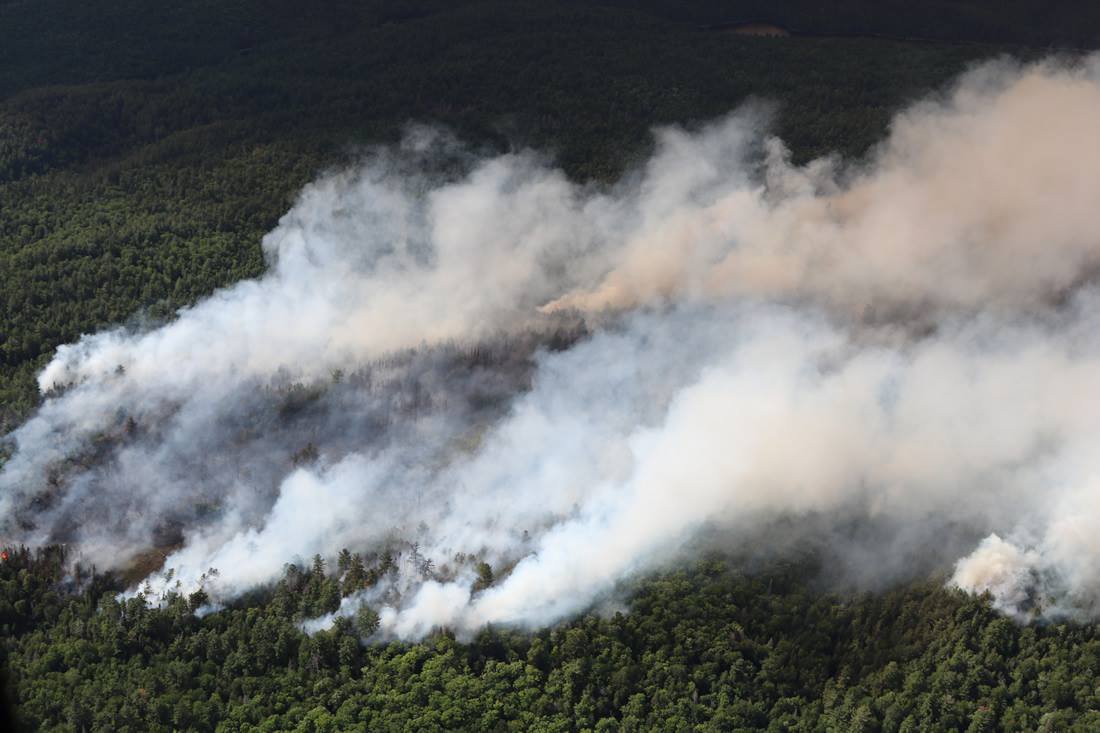

In [33]:
img = Image.open(fnames[0])
img.show()

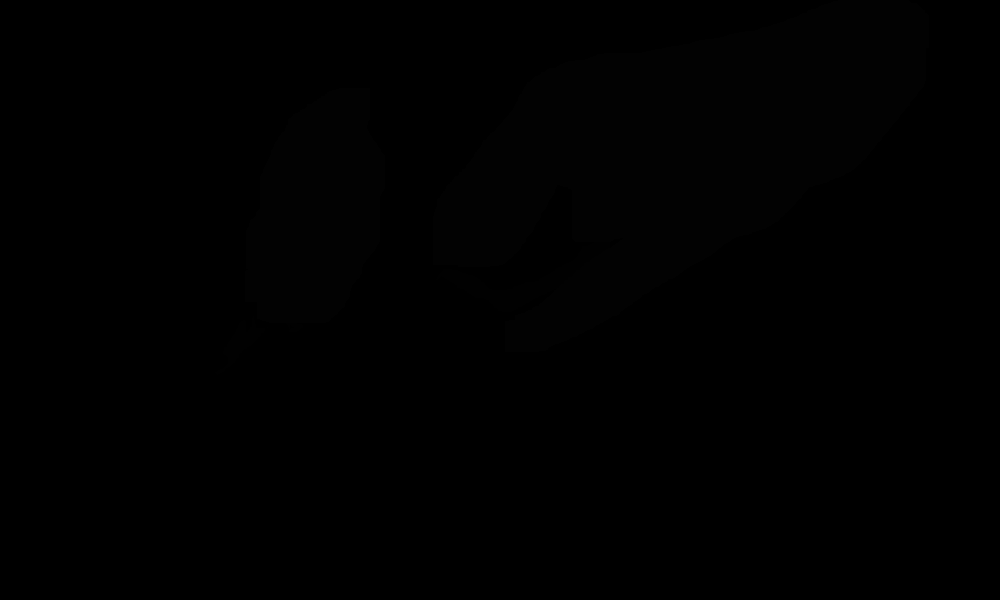

In [34]:
img = Image.open(lbl_names[0])
img.show()

In [35]:
get_y_fn = lambda x: path_label/f'Label_{x.name}'
defaults.use_cuda = True

In [36]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 1,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [37]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [38]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [14]:
# learn.model

SuggestedLRs(valley=3.981071586167673e-06)

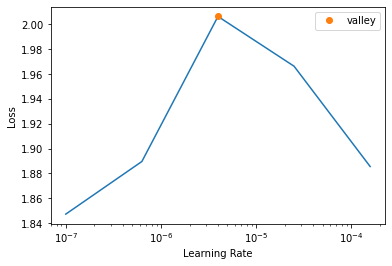

In [15]:
learn.lr_find(stop_div=False, num_it=10)

In [16]:
lr = 4e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,1.073321,0.730232,0.832621,00:05
1,0.796366,0.579161,0.817130,00:05
2,0.729778,0.556085,0.823157,00:05
3,0.632369,0.521780,0.836311,00:05
4,0.569805,0.491275,0.840069,00:05


/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


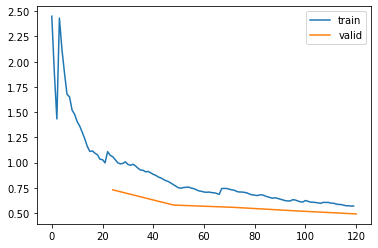

In [17]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [18]:
learn.save('stage-1')
learn.load('stage-1')

SuggestedLRs(valley=0.0008317637839354575)

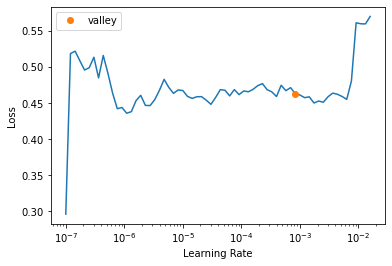

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
lr_max = 2e-7

In [21]:
learn.fit_one_cycle(4, lr_max)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.455385,0.501085,0.838934,00:06
1,0.463213,0.500394,0.837569,00:05
2,0.486384,0.498646,0.837231,00:05
3,0.478089,0.491520,0.840320,00:05


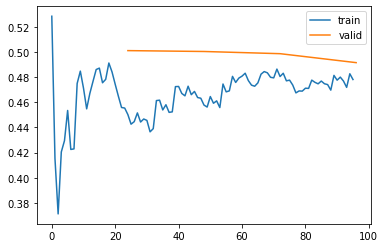

In [22]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/datasets/S_google_wildfire/models/U-res34.pth')

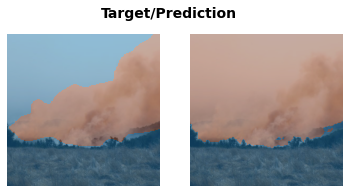

In [23]:
learn.show_results()
learn.save('U-res34')

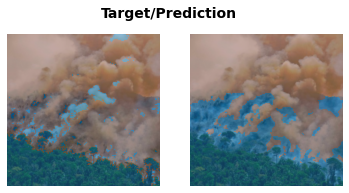

In [24]:
# learn.show_results()
learn.load('U-res34')
learn.show_results()

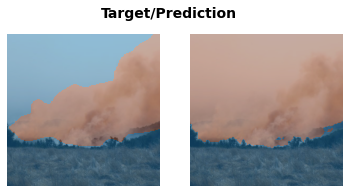

In [25]:
learn.show_results()

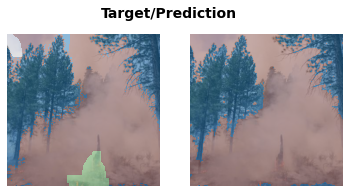

In [26]:
learn.show_results()

Path('/home/qiao/dev/giao/datasets/S_google_wildfire/models/alunet.pth')

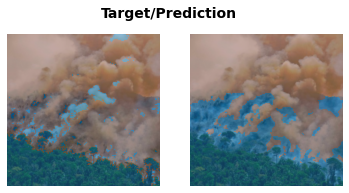

In [27]:
learn.show_results()
learn.save('alunet')

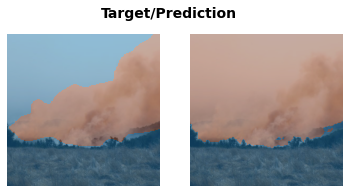

In [28]:
learn.show_results()

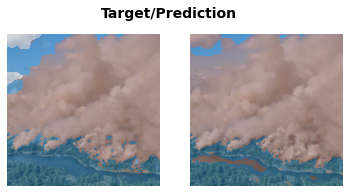

In [29]:
learn.show_results()

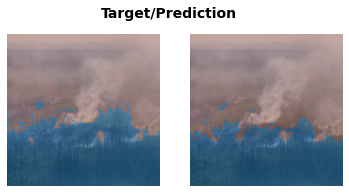

In [30]:
learn.show_results()

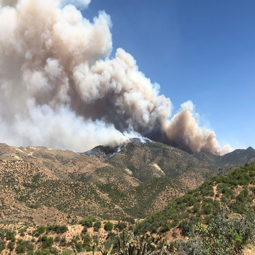

In [49]:
img = Image.open('/home/qiao/dev/giao/datasets/S_google_wildfire/004.png').resize((255, 255))
img.show()

In [50]:
img = PILImage(img)
print(img)

PILImage mode=RGB size=255x255


In [56]:
learn.load('/home/qiao/dev/giao/datasets/S_google_wildfire/models/attunet')
# learn.load('attunet')

FileNotFoundError: [Errno 2] No such file or directory: '/home/qiao/dev/giao/datasets/S_google_wildfire/models/attunet.pth'

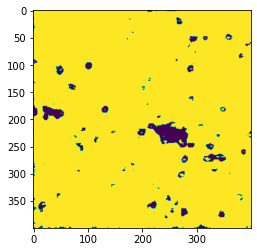

In [57]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

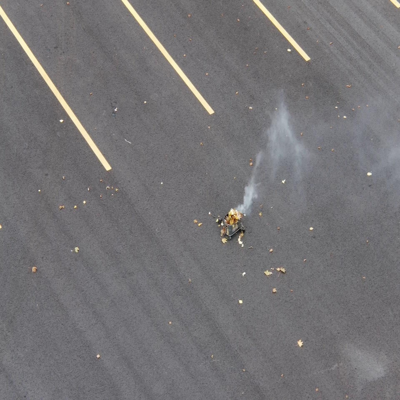

In [55]:
# one time test
import cv2
import numpy as np
from PIL import Image

img = cv2.imread('/home/qiao/dev/giao/datasets/bounding/images/DJI_20211017111122_0003_Z_MP4_1.png')

# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img).resize((400, 400))
im_pil.show()

In [48]:
prediction_mask = learn.predict(im_pil)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

AssertionError: Expected an input of type in 
  - <class 'pathlib.PosixPath'>
  - <class 'pathlib.Path'>
  - <class 'str'>
  - <class 'torch.Tensor'>
  - <class 'numpy.ndarray'>
  - <class 'bytes'>
  - <class 'fastai.vision.core.PILImage'>
 but got <class 'PIL.Image.Image'>